# Quantum Computing in the NISQ Era

In this chapter we introduce variational quantum algorithms (VQA), which is commonly employed in the Noisy Intermediate-Scale Quantum Era. At this stage, the qubits have short coherence time due to the quantum noise, therefore, we expect the functional quantum circuit is **sufficiently shallow**. We often hybrid the quantum and classical computational resource at this stage, similar to the CPU-GPU hybrid workflow, the VQA is a CPU-QPU hybrid workflow.

In [8]:
from functools import partial
import warnings

warnings.filterwarnings("ignore")

import tensorcircuit as tc
import optax
import numpy as np
from matplotlib import pyplot as plt

tc.set_dtype("complex128")
K = tc.set_backend("jax")

## Variational optimization paradigm

Given a multivariable function $f(\theta)$ (we call it the objective function or loss function in variational optimization context), the optimization to identify the minimum of the function and the corresponding parameters $\theta$ is a common task in science and engineering. If gradient $\frac{\partial f}{\partial \theta}$ can be provided either by automatic differentiation or finite difference method, we can update the parameters $\theta$ with **gradient descent**, i.e. $\Delta \theta \propto -\frac{\partial f}{\partial \theta}$. We call this paradigm variational optimization.

*Excercise:* Vanilla example to find the minimum value of quadratic function with two variables $f(x, y)=x^2+y^2$.

6.5984816e-05


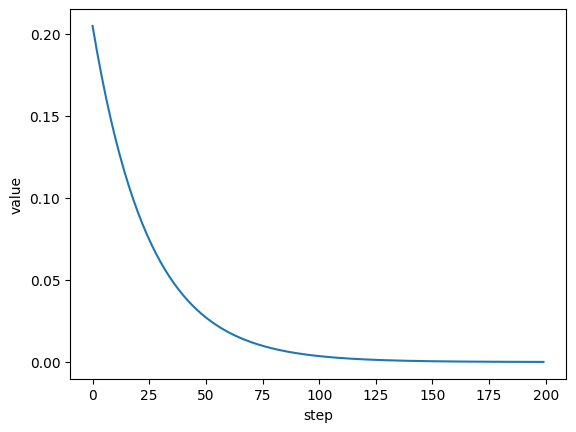

In [7]:
@K.jit
def f(theta):
    return theta[0] ** 2 + theta[1] ** 2


# get the gradient function via automatic differentiation
# jit for acceleration
gradf = K.jit(K.grad(f))
# random initialization
theta0 = K.implicit_randn(shape=[2])
theta = theta0

lbd = 1e-2  # learning rate

fhistory = []

for _ in range(200):
    theta -= lbd * gradf(theta)
    fhistory.append(f(theta))

plt.plot(fhistory)
plt.xlabel("step")
plt.ylabel("value")
print(fhistory[-1])

**Automatic differentiation**: AD has two modes -- reverse mode and forward mode. The former is more suitable for functions with multiple inputs and one output scalar. Reverse mode AD is also know as backpropagation in machine learning community. AD has played a fundamental role in the success of deep learning. The gradient evaluation from AD is obtained by chain rules and free from discretezation error in finite difference methods. In other words, AD (`K.grad` API in tensorcircuit-ng) can give numerical exact gradients for free. 

**Optimization**: for complex objective landscape, the plain gradient descent can be inefficient. There are lots of advanced optimizers based on gradient descent which can incorporate more information such as momentum, etc. One of the famous gradient descent optimizer is Adam.

*Excercise*: rewrite the above example with Adam optimizer.

Text(0, 0.5, 'value')

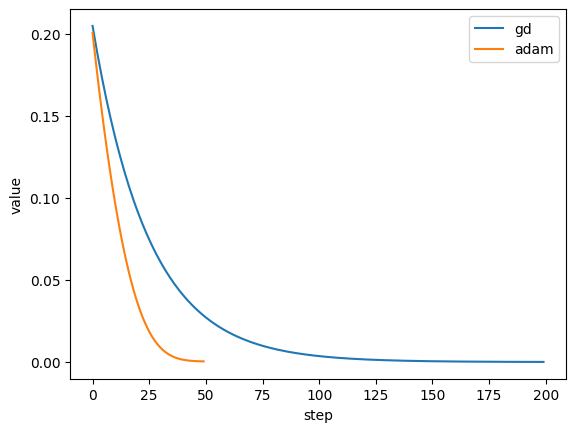

In [10]:
theta = theta0  # parameter initialization

lbd = 1e-2  # learning rate

fhistory_adam = []

opt = K.optimizer(optax.adam(lbd))  # optimizer setup

for _ in range(50):
    grads = gradf(theta)
    theta = opt.update(grads, theta)
    fhistory_adam.append(f(theta))

plt.plot(fhistory, label="gd")
plt.plot(fhistory_adam, label="adam")
plt.legend()
plt.xlabel("step")
plt.ylabel("value")

## Machine Learning in a Nutshell

Deep learning is exactly within the variational optimization paradigm.

*Excercise*: Given a set of points $(x_i, y_i)$, find the optimal linear regression fitting.

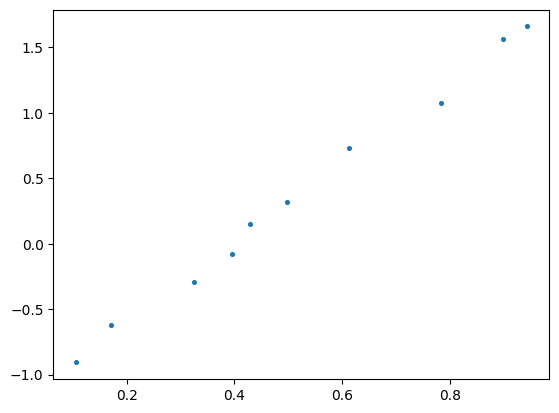

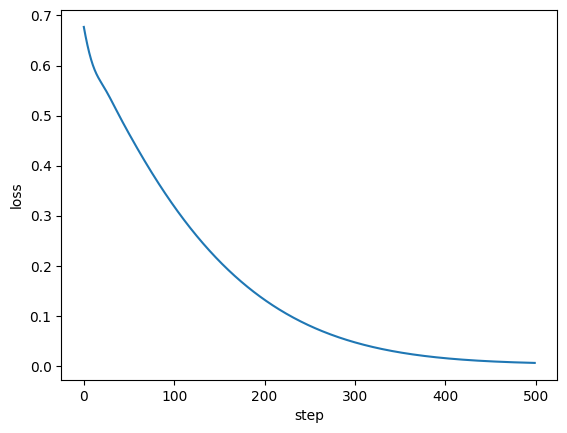

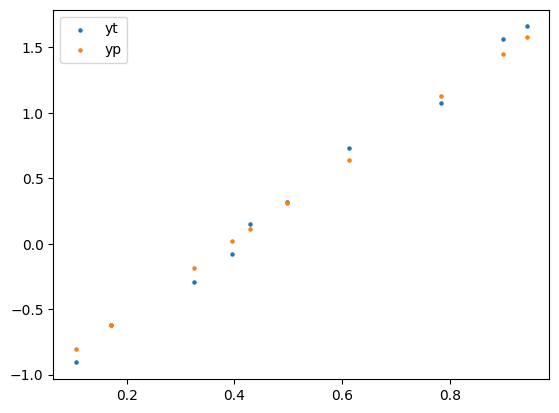

In [31]:
# prepare dataset
k0 = 3.0
b0 = -1.2
datax = np.random.uniform(size=[10])
datay = k0 * datax + b0 + np.random.uniform(-0.1, 0.1, size=[10])
plt.scatter(datax, datay, s=7)
plt.show()


# setup the ML regression model
def nn(theta, x):
    return theta[0] * x + theta[1]


# setup the loss function
def mse(yps, yts):
    return K.mean((yps - yts) ** 2)


def loss(theta, x, yts):
    yps = nn(theta, x)
    return mse(yps, yts)


# variational optimization based on AD, GD and batch processing

vagf = K.jit(K.value_and_grad(loss, argnums=0))
history = []
opt = K.optimizer(optax.adam(1e-2))
theta = K.implicit_randn(stddev=0.1, shape=[2])

for _ in range(500):
    loss, grads = vagf(theta, datax, datay)
    theta = opt.update(grads, theta)
    history.append(loss)

plt.plot(history)
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

plt.scatter(datax, datay, label="yt", s=5)
plt.scatter(datax, nn(theta, datax), label="yp", s=5)
plt.legend()
plt.show()

So called deep learning is as simple as above with the parameterized function `nn` replaced with more complex parameterized functions (such as matrix multiplication or nonlinear activation). The loss function can also be tuned for tasks of different nature such as regression (MSE) or classification (CrossEntropy).

## Rayleigh–Ritz method

The ground state problem in quantum physics can be also casted in the form of variational optimization. Rayleigh variational principle told us that the ground state energy is given as 

$$
E = \text{min}_{\vert \psi\rangle} \langle \psi \vert H\vert \psi\rangle.
$$

This lower bound is easy to prove by doing eigen decomposition of $H$. In practice $\vert \psi\rangle$ is parameterized wavefunction ansatz which can cover the Hilbert space as more as possible while remain compact representation for efficient simulation of the Hamiltonian expectation.

*Excercise*: find the ground state energy of 1D Heisenberg model with RR method.

$$
H = \sum_{i} X_iX_{i+1} + Y_iY_{i+1} + Z_iZ_{i+1}.
$$

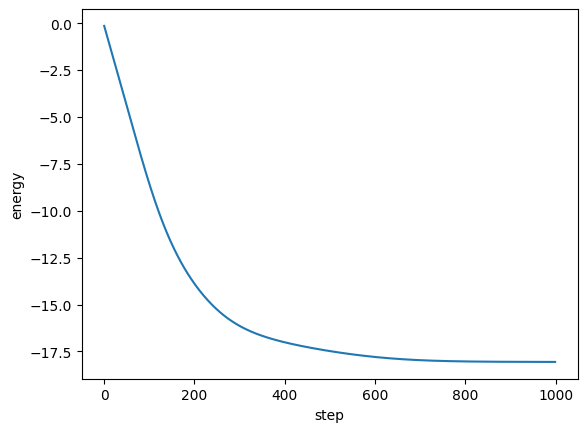

-18.059977073542065
exact ground state energy: -18.06178541796817


In [38]:
L = 10
g = tc.templates.graphs.Line1D(L)
h = tc.quantum.heisenberg_hamiltonian(g, hxx=1, hyy=1, hzz=1)

# the wavefunction ansatz, we use the simplest one:
# directly model each wavefunction components as training parameters


def energy(psi):
    psi /= K.norm(psi)  # ensure the ansatz is normalized
    c = tc.Circuit(L, inputs=psi)
    return K.real(tc.templates.measurements.operator_expectation(c, h))


vagf = K.jit(K.value_and_grad(energy))

psi = K.implicit_randn(shape=[2**L])

history = []
opt = K.optimizer(optax.adam(1e-2))

for _ in range(1000):
    ene, grads = vagf(psi)
    psi = opt.update(grads, psi)
    history.append(ene)

plt.plot(history)
plt.xlabel("step")
plt.ylabel("energy")
plt.show()
print(history[-1])

es, _ = K.eigh(K.to_dense(h))
print("exact ground state energy:", es[0])

For larger system sizes, the direct parameterization for each wavefunction component is infeasible due to the exponentially large Hilbert space. Therefore, we utilize neural networks or tensor networks to parameterize the wavefunction to maintain the good tradeoff between expressivibility and the memory efficiency. In fact, both DMRG and VMC are within the variational optimization paradigm. Now, you understand the underlying mechanism for deep learning and quantum many-body numerical methods within the unified powerful framework of variational optimization. The variational quantum algorithms we are going to introduce below are also under the same umbrella.

## Variational quantum algorithms

In VQA, the parameterized function is modeled by a parameterized quantum circuit, whose rotation angles for the quantum gates are trainable. The loss function can be chose as operator expectation, fidelity, machine learning losses, etc. The schematic workflow for VQA is shown below. 

<img src="../static/vqa.jpg">

**Loss function landscape and parameter shift rules:** The quantum circuit prameter gradients can still be evaluated using AD in TensorCircuit-NG. However, AD doesn't work for real quantum devices. In that case, parameter shift, a finite-difference similar but numerical exact approach emerges. 

*Excercise:* The loss landscape for a single circuit parameter.

**Variational quantum eigensolver (VQE)**

*Excercise:* VQE approach for ground state energy of Heisenberg Hamiltonian.

**Barren plateau**

*Excercise:* Demonstrate that the circuit gradient variance (across different circuit parameter) vanishes exponentially fast with circuit depth.

**Quantum machine learning (QML)**:

*Excercise:* Quantum machine learning approach for linear regression.